In [39]:
import math

def cos_scheduler(step, max_step, lr, fraction):
    return fraction * lr + 0.5 * (
        1 - fraction
    ) * lr * (
        1
        + math.cos(
            math.pi
            * step / max_step
        )
    )


def cos_scheduler(step, max_step, lr, fraction):
    val = lr * (1 + (math.cos(math.pi * step / max_step) - 1) * ((1 - fraction) / 2))

    return val

In [49]:
import matplotlib.pyplot as plt

def get_vals(max_step, lr, fraction):
    # Generate the steps and corresponding learning rates
    steps = list(range(max_step + 1))
    learning_rates = [cos_scheduler(step, max_step, lr, fraction) for step in steps]
    return steps, learning_rates, (lr, fraction)

def make_plot(steps, lrs, labels):
    # Plot the results
    plt.figure(figsize=(10, 6))
    max_lr = 0
    for (learning_rates), label in zip(lrs, labels):
        plt.plot(steps, learning_rates, label=f'lr={label[0]}, fraction={label[1]}')
        if max_lr < label[0]: max_lr = label[0]
    plt.xlabel('Step')
    plt.ylabel('lr')
    plt.title('Cosine Annealing Learning Rate Scheduler')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim((-0.1, max_lr + 0.1))
    plt.show()

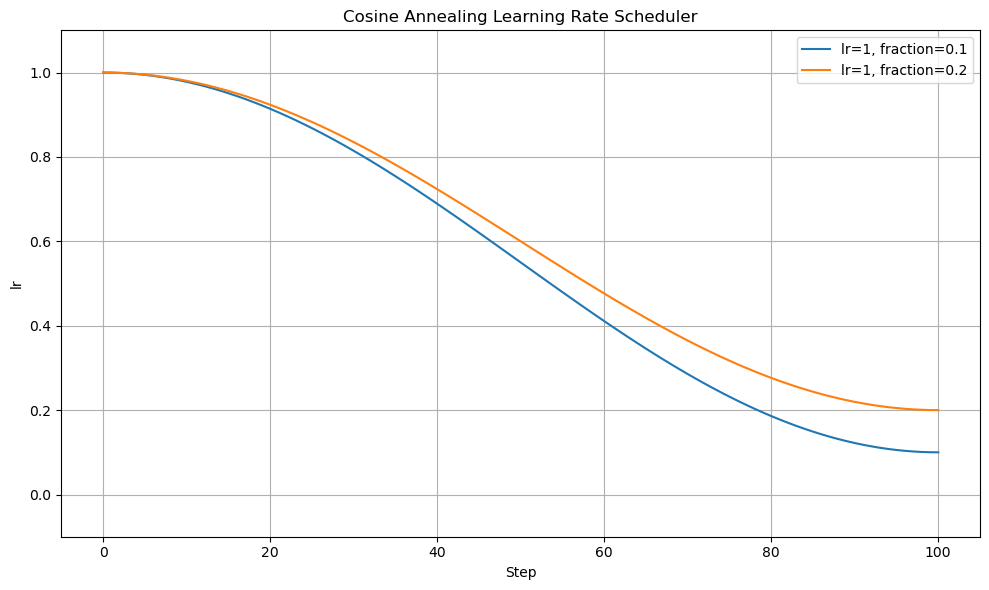

In [50]:
steps, vals1, labels1 = get_vals(100, 1, 0.1)
_, vals2, labels2 = get_vals(100, 1, 0.2)

make_plot(steps, [vals1, vals2], [labels1, labels2])

In [55]:
def rescaled_lr_fraction(relative_fraction, max_step, lr, fraction):
    new_learning_rates = []
    for step in range(max_step + 1):
        old_lr = cos_scheduler(step, max_step, lr, fraction)
        new_learning_rates.append((old_lr - lr) * (1 - fraction * relative_fraction) / (1 - fraction) + lr)

    return new_learning_rates

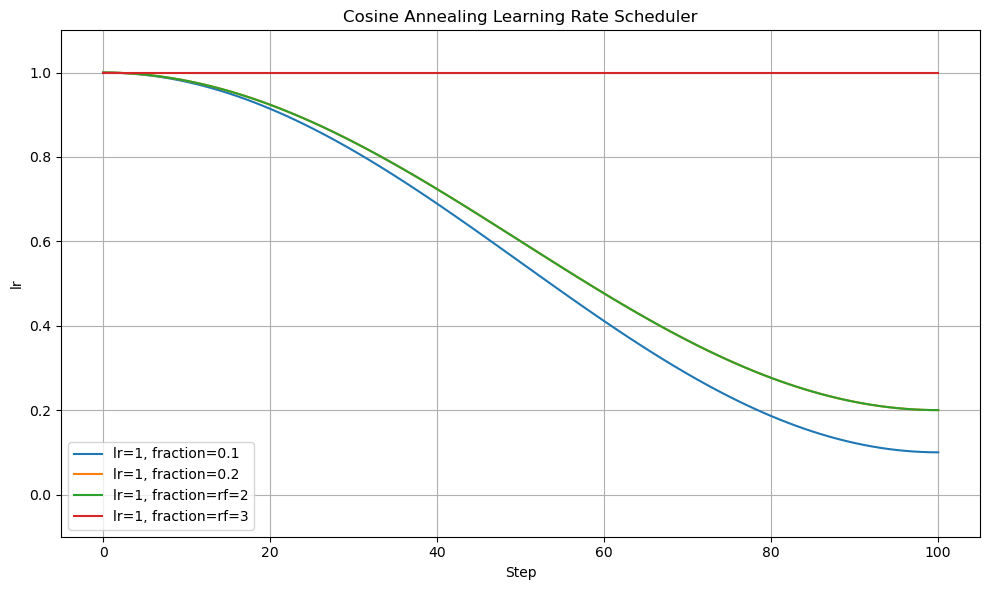

In [56]:
steps, vals1, labels1 = get_vals(100, 1, 0.1)
_, vals2, labels2 = get_vals(100, 1, 0.2)
vals3 = rescaled_lr_fraction(2, 100, 1, 0.1)
vals4 = rescaled_lr_fraction(10, 100, 1, 0.1)

make_plot(steps, [vals1, vals2, vals3, vals4], [labels1, labels2, (1, 'rf=2'), (1, 'rf=3')])

In [2]:
# Define the dictionaries
lr_ratios = {'embedding_layer': 3.333, 'head': 0.666, 'projection': 2.5}
relative_scheduler_fraction = {
    'embedding_layer': 0.666, 
    'head': 0.666, 
    'expert_inner_function': 1.125, 
    'attention': 1.0
}

# Intersect the dictionaries to get the common keys
common_keys = [key for key in lr_ratios.keys() if key in relative_scheduler_fraction]

# Prepare the parameter groups for the optimizer
param_groups = []
lr_ratios_list = []
scheduler_fractions_list = []

for key in common_keys:
    param_group = {
        'params': [key],  # Placeholder for the actual parameters
        'lr': lr_ratios[key]
    }
    param_groups.append(param_group)
    
    lr_ratios_list.append(lr_ratios[key])
    scheduler_fractions_list.append(relative_scheduler_fraction[key])


# Print the lists for LR ratios and scheduler fractions
print("LR Ratios in group order:", lr_ratios_list)
print("Scheduler Fractions in group order:", scheduler_fractions_list)


LR Ratios in group order: [3.333, 0.666]
Scheduler Fractions in group order: [0.666, 0.666]
